In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

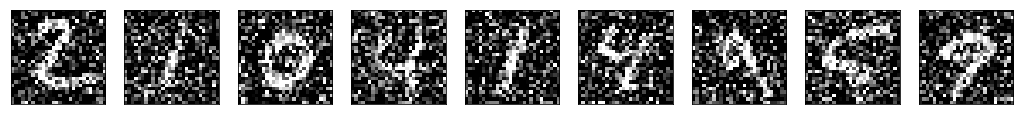

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 125us/step - loss: 0.1788 - val_loss: 0.1263
Epoch 2/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1195 - val_loss: 0.1147
Epoch 3/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1115 - val_loss: 0.1069
Epoch 4/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.1077 - val_loss: 0.1083
Epoch 5/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1053 - val_loss: 0.1028
Epoch 6/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1040 - val_loss: 0.1023
Epoch 7/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1030 - val_loss: 0.1011
Epoch 8/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.1022 - val_loss: 0.1019
Epoch 9/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.1016 - val_loss: 0.

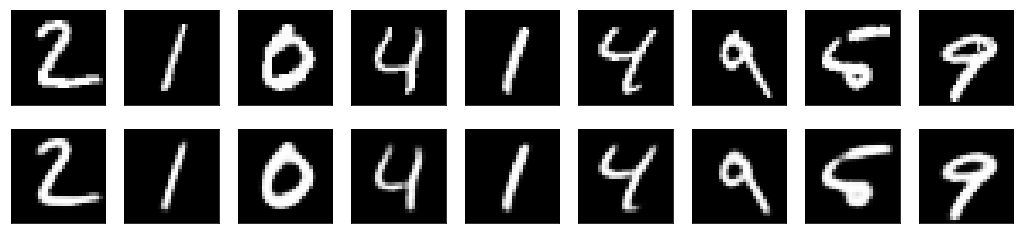

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(
    x_train_noisy,
    x_train_noisy,
#     x_train,
    epochs=100,
    batch_size=1024
#                 shuffle=True
#                 validation_data=(x_test_noisy, x_test)
               )

Epoch 1/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.5923
Epoch 2/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.5404
Epoch 3/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.5263
Epoch 4/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.5192
Epoch 5/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.5134
Epoch 6/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.5090
Epoch 7/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.5056
Epoch 8/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.5030
Epoch 9/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.5010
Epoch 10/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.4993
Epoch 11/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.4976
Epoch 12/100
60000/60000 [===============

60000/60000 [==============================] - 3s 53us/step - loss: 0.4233
Epoch 95/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.4231
Epoch 96/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.4228
Epoch 97/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.4223
Epoch 98/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.4221
Epoch 99/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.4216
Epoch 100/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.4214


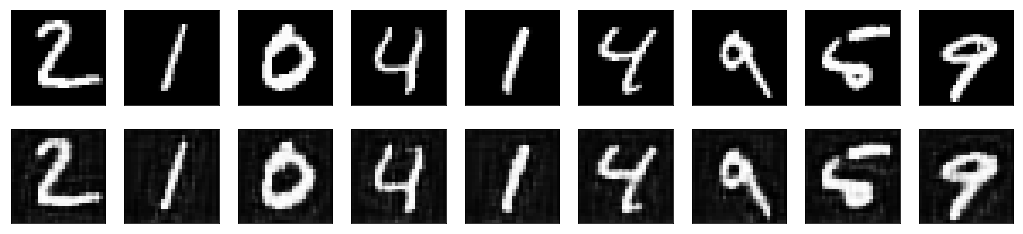

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()